# Film production.

# 1.0 Introduction

## 1.1 Business Understanding

One of the most well-known genres of art, film production has millions of spectators worldwide. There are many ways that movies can be communicated to viewers as a result of the development of various films genres over time.

Are budgets and box office grosses connected?


After observing that all the big companies were producing original video content, Microsoft made the decision to capitalize on the rising popularity of films. It is my duty to research the categories of movies that are doing the best at the box office and to translate findings into useful advice. I intend to conduct studies and then use the results to develop data-driven conclusions that will help my client.

## 1.2 Data Understanding

The dataset for this project was compiled from several sources. There are five movie datasets from:
* Box Office Mojo data
* IMDB  data  
* popular movies data
* top rated movies data

For this project, perfomance of a movie will be based on the return on investment (ROI). The formulae used to calculate ROI is: (collection from box office)-(the budget cost). This will be used to classify if the movie perfomed well or not.

The data sets had other columns which were dropped and the analysis will we concentarded on mainly,rating,title,genre,runtime and genre. The first rows to be dropped were those that had any missin value in the revenue column since they could not be classified based on ROI.

definitions of terms used during the eda process

# 2.0 Data Preparation Process

## 2.1 Loading Libraries

In [ ]:
#pip install WordCloud

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

import sqlite3

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud 

# Read sqlite query results into a pandas DataFrame
conn = sqlite3.Connection("Data/im.db")

## 2.2 Loading datasets

In [2]:
# Loading of the data sets.
  
#box office gross dataset
box_office_df = pd.read_csv('Data/bom.movie_gross.csv.gz')

#Teddy Newton movie budgets dataset
movie_budgets_df = pd.read_csv('Data/tn.movie_budgets.csv.gz')

#the movie data base dataset
tmdb_df = pd.read_csv('Data/tmdb.movies.csv.gz')

#Rotten Tomatoes reviews dataset
rt_reviews_df = pd.read_csv('Data/rt.reviews.tsv.gz', sep='\t', encoding = 'unicode_escape')

#Rotten Tomatoes movie info dataset
rt_movie_info_df = pd.read_csv('Data/rt.movie_info.tsv.gz', sep='\t', encoding = 'unicode_escape')


In [3]:
 #Read sqlite query results into a pandas DataFrame
#joining the two tables using the movie_id key

joint_query = """
SELECT *
FROM movie_basics
JOIN movie_ratings USING (movie_id)
;
"""
joint_query = pd.read_sql(joint_query, conn)
joint_query.tail(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5
73855,tt9916160,Drømmeland,Drømmeland,2019,72.0,Documentary,6.5,11


# 3.0 Data Cleaning

### 3.0.1 combining of the data sets to a final data set

In [7]:
#the data sets were all combied on common keys before cleaning of the data

joint_query.dropna(inplace = True)

box_office_df.dropna(inplace = True)

box_office_df.rename(columns = {'title':'original_title'}, inplace = True)

combined_data_1 = pd.merge(joint_query, box_office_df, how='inner', on='original_title')

movie_budgets_df.dropna(inplace = True)

movie_budgets_df.rename(columns = {'movie':'original_title'}, inplace = True)
 
# Find the columns that aren't in the first DataFrame
different_cols = combined_data_1.columns.difference(movie_budgets_df.columns)
 
# Filter out the columns that are different.
data3 = combined_data_1[different_cols]
 
# Merge the DataFrames
data = pd.merge(movie_budgets_df, data3, left_index=True,
                     right_index=True, how='inner')
data.shape

(1517, 16)

In [8]:
final_data = data.drop(['id','foreign_gross','movie_id','primary_title','start_year','year'], axis=1)

### 3.1 cleaning of the final dataset

#### 3.1.0 fixing structural issues
removal of the **$** from production_budget, domestic_gross and worldwide_gross


In [9]:
final_data['production_budget'] = final_data['production_budget'].str.replace('[\$\,]','',regex=True)
final_data['domestic_gross'] = final_data['domestic_gross'].str.replace('[\$\,]','',regex=True)
final_data['worldwide_gross'] = final_data['worldwide_gross'].str.replace('[\$\,]','',regex=True)


#### 3.1.1 changing data types 
production_budget, domestic_gross and worldwide_gross

In [10]:
final_data['production_budget'] = pd.to_numeric(final_data['production_budget']) 
final_data['domestic_gross'] = pd.to_numeric(final_data['domestic_gross'])
final_data['worldwide_gross'] = pd.to_numeric(final_data['worldwide_gross'])

final_data.dtypes

release_date          object
original_title        object
production_budget      int64
domestic_gross         int64
worldwide_gross        int64
averagerating        float64
genres                object
numvotes               int64
runtime_minutes      float64
studio                object
dtype: object

In [12]:
list(final_data.columns)

['release_date',
 'original_title',
 'production_budget',
 'domestic_gross',
 'worldwide_gross',
 'averagerating',
 'genres',
 'numvotes',
 'runtime_minutes',
 'studio']

### data after cleaning

In [13]:
final_data.shape

(1517, 10)

In [ ]:
final_data.info()

## 4.0 Exploratory Data Analysis

### 4.0.1 Profit Calculation

I now want to discuss the relationship between a movie's budget and how much it earns at the box office. I'll focus on the **Domestic gross**, which includes all ticket sales revenue from US and Canadian theaters.

I'll use the Pearson correlation coefficient to measure the linear correlation   between the production  budget and box office domestic gross.


This result indicates a correlation of **0.6** between production budget and the domestic gross.
This implies a **moderate** strength of relationship.

,production_budget,domestic_gross,worldwide_gross,averagerating,numvotes,runtime_minutes,domestic_profit
production_budget,1.000000,0.597889,0.680573,-0.003916,0.150140,-0.001864,0.114098
domestic_gross,0.597889,1.000000,0.933668,-0.018694,0.084532,0.000663,0.864562
worldwide_gross,0.680573,0.933668,1.000000,-0.003446,0.096666,-0.000801,0.730514
averagerating,-0.003916,-0.018694,-0.003446,1.000000,0.413918,0.247586,-0.020714
numvotes,0.150140,0.084532,0.096666,0.413918,1.000000,0.368927,0.010642
runtime_minutes,-0.001864,0.000663,-0.000801,0.247586,0.368927,1.000000,0.001990
domestic_profit,0.114098,0.864562,0.730514,-0.020714,0.010642,0.001990,1.000000


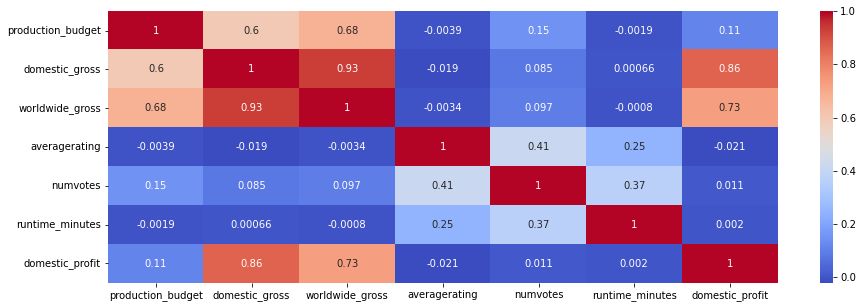

In [14]:
final_data['domestic_profit'] = final_data['domestic_gross'] - final_data['production_budget']
correlation_df = final_data.iloc[:, [6,2,3,4,10]].head(13)
correlation = final_data.corr()
plt.figure(figsize=(15,5))
sns.heatmap(correlation, xticklabels = correlation.columns,
            yticklabels = correlation.columns,
            cmap = 'coolwarm', annot = True);
correlation

###  4.0.2 Genre Analysis

#### How are genres changing over time?

I've analyzed genre ties in this section. Because most of the movies in my datasets fit into more than one genre,it would be interesting to learn how the different types are related and perhaps check on how they affect the popularity of the movies compared against number votes.


In [15]:
final_data.sort_values(by='release_date', ascending=True)

,release_date,original_title,production_budget,domestic_gross,worldwide_gross,averagerating,genres,numvotes,runtime_minutes,studio,domestic_profit
1408,"Apr 1, 2005",Sin City,40000000,74103820,158527918,7.1,"Action,Adventure,Comedy",244024,118.0,BV,34103820
271,"Apr 1, 2010",Clash of the Titans,125000000,163214888,493214888,5.5,"Adventure,Comedy,Fantasy",92940,102.0,Uni.,38214888
826,"Apr 1, 2011",Hop,63000000,108085305,188657593,7.0,Drama,10,105.0,Par.,45085305
1003,"Apr 10, 1998",City of Angels,55000000,78750909,198750909,6.4,"Action,Adventure,Drama",57033,112.0,Fox,23750909
1274,"Apr 11, 1997",Anaconda,45000000,65598907,136998907,7.6,"Drama,History,Thriller",263004,142.0,BV,20598907
...,...,...,...,...,...,...,...,...,...,...,...
1491,"Sep 6, 2002",City by the Sea,40000000,22433915,22433915,5.4,"Comedy,Romance",39936,110.0,STX,-17566085
1482,"Sep 7, 2001",The Musketeer,40000000,27053815,27053815,4.9,"Action,Crime,Drama",6805,89.0,SGem,-12946185
1224,"Sep 7, 2007",3:10 to Yuma,48000000,53606916,71171825,3.5,Horror,303,94.0,Uni.,5606916
870,"Sep 9, 2011",Contagion,60000000,75658097,137551594,5.5,"Action,Adventure,Drama",100467,105.0,TriS,15658097


In [16]:
genre_frequncy = dict(final_data['genres'].str.split(',', expand=True).stack().value_counts())

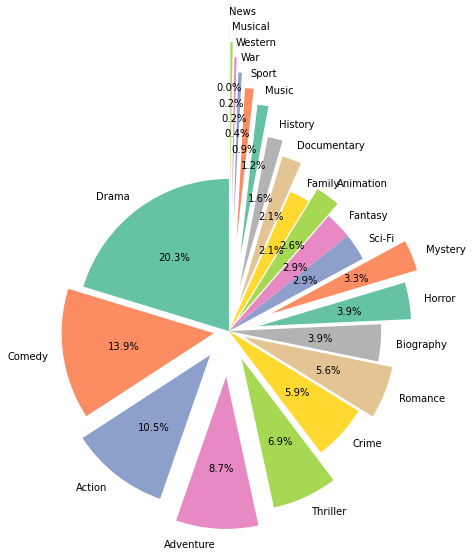

In [26]:
fig, ax = plt.subplots(figsize =(10, 7))
explode = (0.0, 0.1, 0.2, 0.3, 0.2, 0.0,0.1,
           0.0, 0.2, 0.3, 0.0, 0.0,0.1, 0.0,
           0.2, 0.3, 0.5, 0.6,0.7, 0.8, 0.9, 1.0)

plt.pie(genre_frequncy.values(), labels=genre_frequncy.keys(),
        startangle=90, autopct='%.1f%%', colors=plt.cm.Set2.colors,
        explode = explode)

plt.show();

Drama movies had the highest frequency counts and it was the most distributed genre across the combinations.

#### Which genres have the highest correlation between budget and market success?

To find the most expensive movies based on production budget, I sort my production budget in descending order and checked for the top 100.

In [18]:
top_expensive_genre = final_data.sort_values(by=['production_budget'], ascending=False,).head(100)

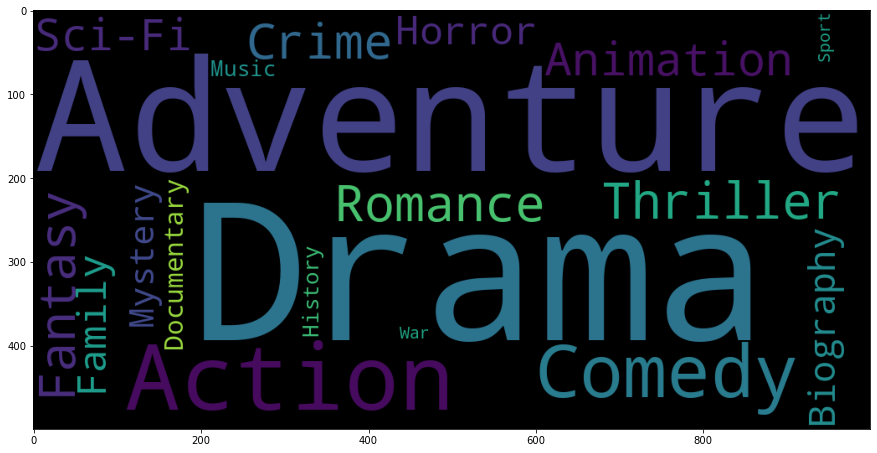

In [19]:
genres_in_top_expensive_movies = dict(top_expensive_genre['genres'].str.split(',', expand=True).stack().value_counts())

wordcloud = WordCloud(width = 1000, height = 500,
                     collocations = False, 
                      ).generate_from_frequencies(genres_in_top_expensive_movies)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud);

This indicates, top perfoming genres are also the top expensive movies to produce.This means that in  majority of the cases, a larger budget has also resulted in a higher domestic box office gross.

Since most of the movies in the dataset have multiple Genres, I decided to split each of them to have a count plot and see how they are distributed.
From the value counts of the genres, drama had the highest value count while news had the least count.

### 4.0.3 Runtime Analysis.

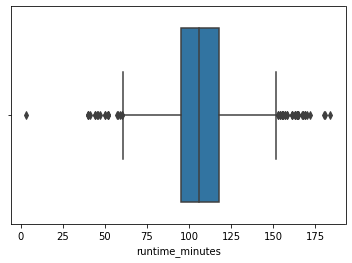

In [23]:
sns.boxplot(x=final_data["runtime_minutes"]);

In [20]:
final_data['runtime_minutes'].mean()

107.62491760052735

The average runtime of most movies was at 100 minutes.I decided to check how it has changed over the years.

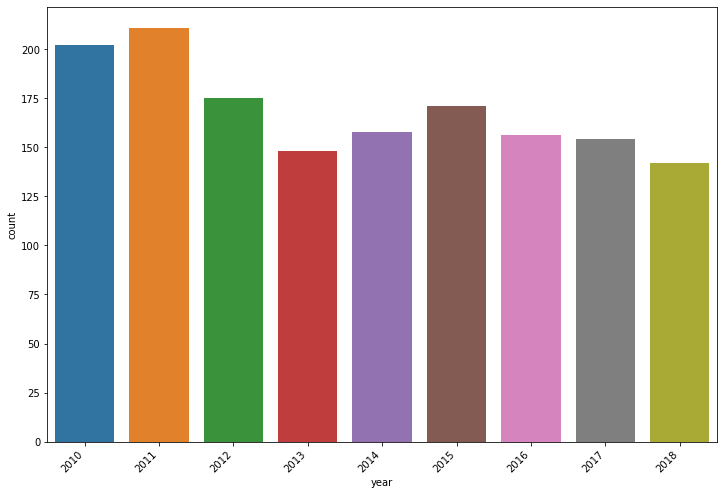

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(data=data['runtime_minutes'], x=data['year'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Its is clear, the runtime for movies has not changed over the yaers, much.Its still 

In [28]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 1516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1517 non-null   object 
 1   original_title     1517 non-null   object 
 2   production_budget  1517 non-null   int64  
 3   domestic_gross     1517 non-null   int64  
 4   worldwide_gross    1517 non-null   int64  
 5   averagerating      1517 non-null   float64
 6   genres             1517 non-null   object 
 7   numvotes           1517 non-null   int64  
 8   runtime_minutes    1517 non-null   float64
 9   studio             1517 non-null   object 
 10  domestic_profit    1517 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 182.2+ KB


## 5.0 Conclusion

* Drama, Comedy and Action are the top genres. As seen in the pie chart and wordcloud
* Production budget and domestic gross have a high correlation.
* Drama genre continues to dominate most of the movies being produced.
* Runtime of movies has not greatly changed over the yaers as seen from the analysis.
* Significant number of movies go into loss.
* Movies that audience easily relates with are popular and have higher ratings.


## 6.0 Recommendations

* To enter into the film industry, it is important to consider short movies at an average of 50 minutes.

* There are factors that affect the movie perfomance after it has been prodced these include release date and the streaming platforms.

* More research could be done to understand what causes movies to be non profitable. This could help avoid loss in the movie industry.